<a id=top></a> 
**Table of Content**


- [General Introduction to our model](#introduction)
- [Baseline](#baseline)
- [The ResNet without any kind of normalization](#nonormalization):
  - [Adam Optimizer](#adam):
    - [batch_size=32](#32adam)
    - [batch_size=16](#16adam)

  - [Stochastic Gradient Descent](#sgd)
    - [batch_size=32](#32sgd)
    - [batch_size=16](#16sgd)

  - [AdaDelta Optimizer](#AdaDelta) 

  - [Bootstrap testing](#bootstrap)

  - [Dropping Head](#head)

- [The ResNet with normalization](#normalization):
  - [normalization type n°1](#norm1)
  - [normalization type n°2](#norm2)
  - [normalization type n°3](#norm3)

- [Appendix](#appendix)
  - [Extra Models](#newmodels)
    - [AlexNet](#alexnet)
    - [Vgg16](#vgg16)
    - [LSTM-CNN](#lstm-cnn)
  - [Extra ResNet attempts](#otherResNet)


<a id=introduction></a> 
# The Classification Model

As for the classification part, we have tested many algorithms: *ResNet*, *AlexNet*, *VGGNet* and *LSTM-CNN* models. We chose these models because they are the ones most commonly used for image classification. \
Among them, we focused on *ResNet* because we considered it the best option since it overcomes the issue of the vanishing gradient problem, which instead might affect many deep CNN models. Indeed, as opposed to the above-mentioned models, *ResNet* makes use of two shortcut connections to avoid this issue: *Identity shortcut* and *Projection shortcut*. 
Coherently with our expectations, *ResNet* returns the best performance among the models trained.

We have decided to build and train a *ResNet30* from scratch, without relying on transfer learning.
The reason relies on the peculiar nature of our dataset. Indeed, our dataset, after the keypoints retrieval, consists of matrices of distances between body parts. Its uniqueness makes it difficult to compare it with other dataset, and thus to apply a pre-trained classifier.

 

The *Resnet* we use has the following structure:

1) *Input* with the shape of our distance matrices \
2) A *Convolutional2D layer* with 64 filters \
3) 2, 5, 5, 2 *residual blocks* (the skip connections typical of *ResNet*) with an increasing number of filters \
4) *Average Pooling layer* with pool size set to 4 to reduce the size of the feature map \
5) *Flatten Layer* to convert to pooled feature map to a single vector \
6) *Dense Layer* with 7 output as our final classes 



In the next cell you can find the keras implementation of the model.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns 
import tensorflow as tf

from shutil import copyfile

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow import  Tensor, keras
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger

In [ ]:
''' Defining the model'''

def relu_bn(inputs) :
    """
    After each conv layer, a Relu activation and a Batch Normalization are 
    applied

    Parameters
    ----------
    inputs: Tensor  
      Input tensor from the previous layer

    Returns
    --------
    bn: batch normalized layer
    """
    
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)

    return bn

def residual_block(x, downsample, filters, kernel_size = 3):
    """
    This function constructs a residual block. It takes a tensor x as input and 
    passes it through 2 conv layers

    Parameters
    ----------
    x: Tensor 
      Input tensor from the previous layer (or Input if it is the
    first one)

    downsample: bool 
      When true downsampling is appplied: the stride of the 
      first Conv layer will be set to 2 and the kernel size passes from 3 to 1

    filters: int 
      Number of filters applied to the data

    kernel_size: int 
      Kernel size, default value equals to 3
    
    Returns
    --------
    out: layer of the residual block calculated
    """

    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)

    y = relu_bn(y)

    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    # With the downsaple parameter set to True:
    # the strides of the first Conv are set to 2
    # the kernel size of the conv layer on the input passes from 3 to 1
    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)

    # The input x is added to the output y, and then the relu activation and 
    # batch normalization are applied           
    out = Add()([x, y])
    out = relu_bn(out)

    return out

def create_res_net(optimizer):
    """
    A function to create the ResNet. It puts together the two other functions 
    already defined
    
    Parameters
    ----------
    optimizer: str 
      The name of the optimizer we want to use to compile the model

    Returns
    ----------
    Model initalized and compiled with the optimizer
    """

    # The dimension of our distance matrices
    inputs = Input(shape=(105, 150, 1))

    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    # The residual function is called to add the skip connections
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t,
                               downsample=(j==0 and i!=0), 
                               filters=num_filters)

        # The number of filters applied to the residual blocks are increasing 
        # (64,128,256,512)    
        num_filters *= 2
    
    # Average pooling layer to reduce the dimension of the input by computing 
    # the average values of each region
    t = AveragePooling2D(4)(t)

    # Flatten layer 
    t = Flatten()(t)

    # Dense layer to produce the probabilities of all the classes 
    outputs = Dense(7, activation='softmax')(t)

    # Initalizing the model
    model = Model(inputs, outputs)

    # Sparse categorical crossentropy since we do not have one-hot arrays for 
    # the probabilities
    model.compile(optimizer= optimizer,
                  loss= 'sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
# As input we start from arrayX and arrayY: they report all the distances
# obtained from the Swapped and Smoothed coordinates, without any kind of 
# normalization applied

arrayX = np.load('../arrays/arrayX.npy')
arrayY = np.load('../arrays/arrayY.npy')
classes = sorted(os.listdir('../pose_output/'))

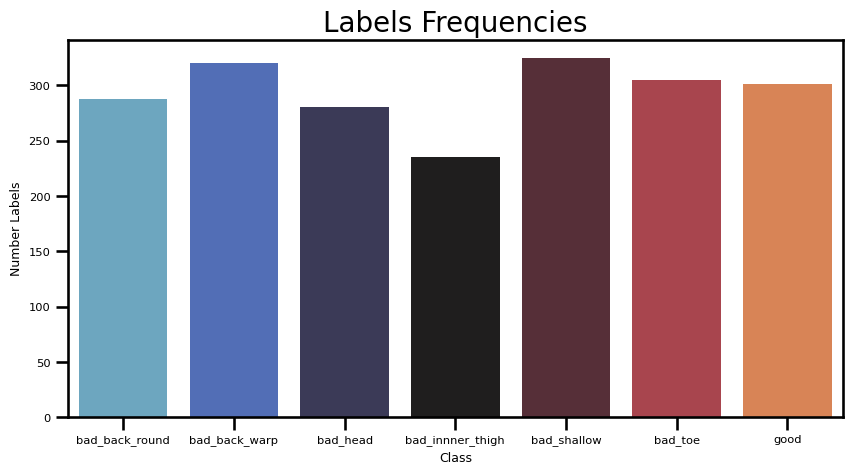

In [ ]:
# Distribution pre-split
dict_labels = {i:classes[i] for i in range(len(classes))}
df = pd.DataFrame(arrayY, columns=['Labels'])
df['Class'] = df.apply(lambda x: dict_labels.get(x['Labels']), axis=1)

# Plot
sns.set_context("talk", font_scale=0.5)
fig, ax = plt.subplots(figsize=(10,5), dpi = 100) 
df2 = df.groupby('Class').count().reset_index()\
        .rename({'Labels':'Number Labels'},axis=1)
sns.barplot(x= 'Class', y = 'Number Labels', data = df2, palette = 'icefire')
ax.set_title('Labels Frequencies', fontsize=20);

****Comment**** \
We plot the distribution of our classes to get an idea of the balance among the different labels before splitting the dataset.\
The dataset is well balanced: all categories of squat are present almost in the same ratio.


<a id=baseline></a> 
# Baseline : LSTM-CNN directly on input videos 

As in every classification setting, we start with a baseline to use as benchmark.
Since the *ResNet* we are going to implement takes as input the body distances, here we first evaluate a model with a more 'traditional' approach. Therefore, instead of using the distance matrices, we rely on the information retrived from the original video, i.e. *pixels for every frame*. 

We think that this implementation can be a fair baseline. Indeed, it is much more straightforward to think about, as not much action is required on the input side. Though, as aforementioned, we don't believe that such model is the best for this task, so we focused our forces on the distance-matrices approach, which is more generalizable.

This implementation takes much more time than subsequent ones. To overcome some computational problems, we limit the input to the first 70 frames and we rescaled every frame into a 64x64 image.\
We propose the *LSTM-CNN* model because, since we deal with videos and not single images, it should provide a better prediction.

In [ ]:
def train_val_test_split(X, Y, val_size=0.2, test_size=0.2):
  """
  Shuffle the data and split into train-val-test.
  """
  X_aux, X_test, y_aux, y_test = train_test_split(X, Y, test_size=test_size, 
                                                  shuffle=True, random_state=1)

  val_aux_size = val_size/(1-test_size)
  X_train, X_val, y_train, y_val = train_test_split(X_aux, y_aux, 
                                                    test_size=val_aux_size, 
                                                    shuffle=True, random_state=1)

  return X_train, X_val, X_test, y_train, y_val, y_test

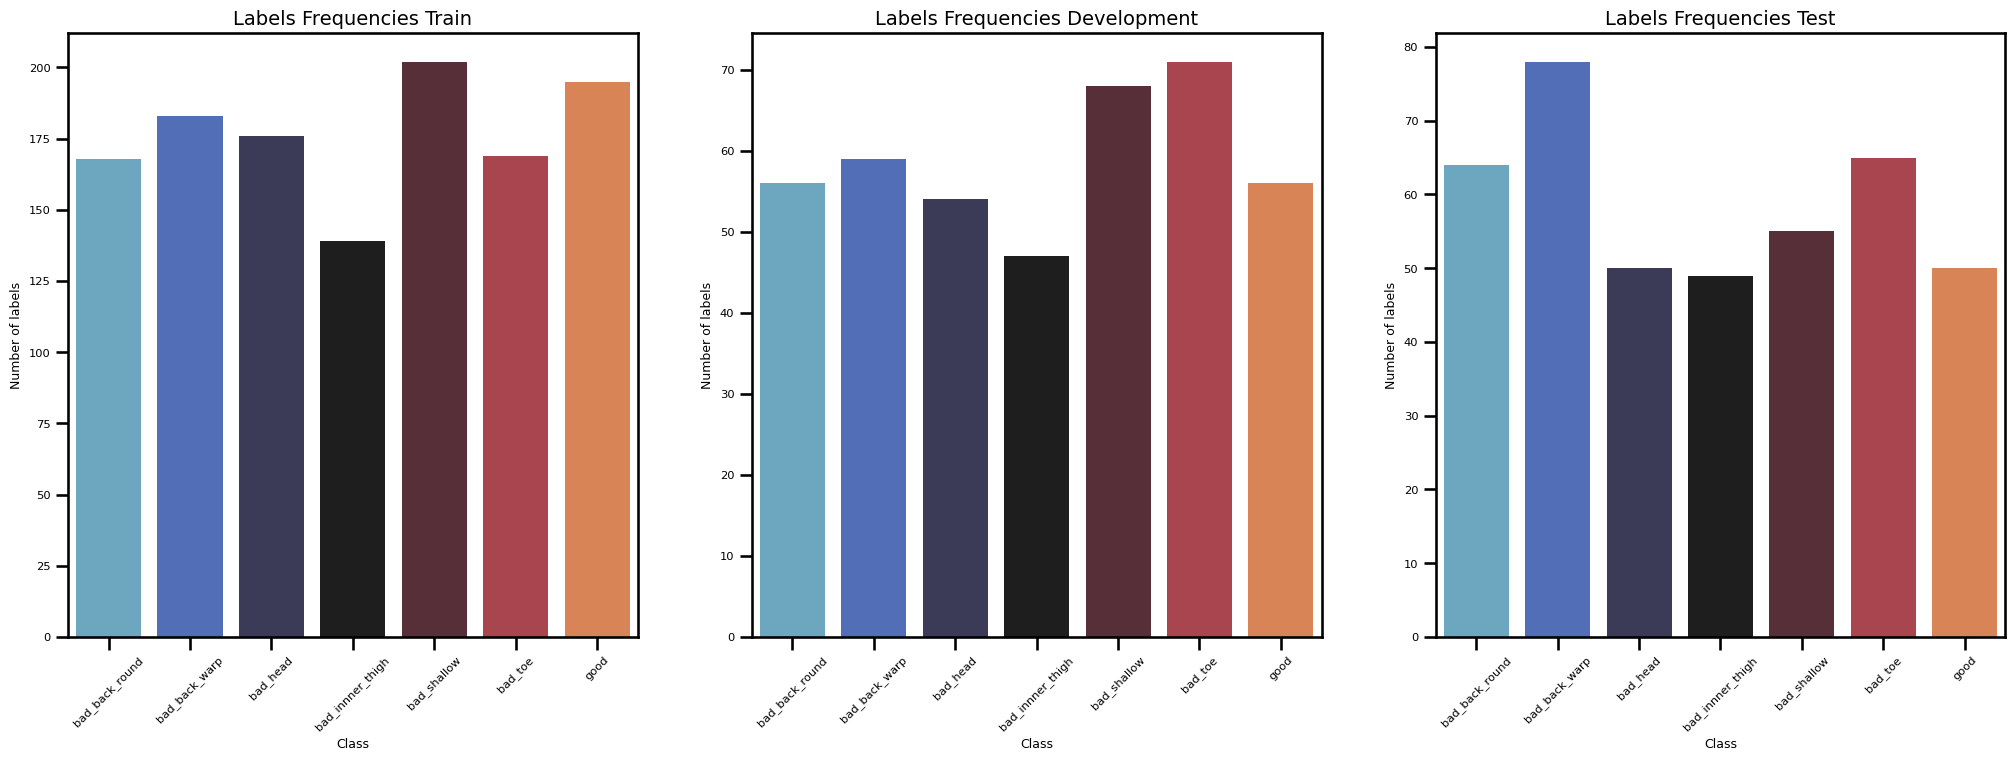

In [ ]:
y_train, y_val, y_test, y_train_df, y_val_df, y_test_df = train_val_test_split(arrayY, df) 

#Plotting Distributions
fig, axs = plt.subplots(1,3, figsize=(25,8), dpi = 100) 
names = ['Train', 'Development', 'Test']
dfs = [y_train_df, y_val_df, y_test_df]
for h in range(3):  
    df2 = dfs[h].groupby('Class').count().reset_index()\
                .rename({'Labels':'Number of labels'}, axis=1)
    sns.barplot(x= 'Class', y = 'Number of labels', data = df2, 
                palette = 'icefire', ax = axs[h])
    axs[h].set_title('Labels Frequencies '+names[h], fontsize=14)
    axs[h].set_xticklabels(axs[h].get_xticklabels(), rotation = 45);

****Comment**** 

    The balance amang labels we had at the beginning is fairly respected after the splitting.

In [ ]:
def frames_extraction(video_path, num_frames = 70,
                      img_height = 64, img_width = 64):
    """
    Function that will extracts the frames from a given video. It can also
    resize the given input

    Parameters
    ----------
    video_path: str
      Path of the input video we want to retrieve 
    num_frames: int
      Number of frame to consider
    img_height: int
      Resize value for height
    img_width: int 
      Resize value for width

    Returns
    ----------
    List containing all the retrived frames. Shape = 70x64x64x3
    """

    frames_list = []
    cap = cv.VideoCapture(video_path)

    # Used as counter variable 
    for i in range(num_frames)
        success, image = cap.read() 
        if success:
            image = cv.resize(image, (img_height, img_width))
            frames_list.append(image)
            
    return frames_list


  def create_data(input_dir):
    """
    Functions that creates the input array. 

    Parameter
    ---------
    input_dir: str 
      Directory of videos we want to retrive the frames from

    Returns
    ---------
    X Array with shape of type:
    (number of video, number of frames, img_height, img_width, color channels)
    """

    X = []
    Y = []

    for c in sorted(os.listdir(input_dir)):
      print(c)
      DIR = input_dir+c+'/'
      for f in sorted(os.listdir(DIR)):
        frames = frames_extraction(DIR+f)
        X.append(frames)

    return np.array(X)

In [ ]:
""" creating the arrays """
array_X_pixels = create_data('../Video_Dataset') 
np.save('../arrays/framesX.npy', array_X_pixels)

bad_back_round
bad_back_warp
bad_head
bad_innner_thigh
bad_shallow
bad_toe
good


In [ ]:
""" splitting the arrays """
array_X_pixels = np.load('../arrays/framesX.npy')
X_train_pixels, X_val_pixels, X_test_pixels, y_train, y_val, y_test = train_val_test_split(array_X_pixels, arrayY)

In [ ]:
""" defining the model """
model_lstm = keras.models.Sequential([
    keras.layers.ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (70, 64, 64, 3)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(7, activation = "softmax")             
])

opt = keras.optimizers.SGD(lr=0.001)
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
""" running the model """
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath='../weights/OtherModels/CNNLSTM_SGD_weights_16batch_pixels.hdf5',
      save_weights_only=False,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)

batch_size = 8 
epochs = 50 

history = model_lstm.fit(X_train, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_lstm.evaluate(X_test, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/OtherModels/CNNLSTM_SGD_weights_16batch_pixels.csv')

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/50
154/154 - 165s - loss: 2.0338 - accuracy: 0.1607 - val_loss: 1.9217 - val_accuracy: 0.1825
Epoch 2/50
154/154 - 167s - loss: 1.9142 - accuracy: 0.2005 - val_loss: 1.9042 - val_accuracy: 0.1752
Epoch 3/50
154/154 - 168s - loss: 1.8452 - accuracy: 0.2508 - val_loss: 1.8973 - val_accuracy: 0.2068
Epoch 4/50
154/154 - 167s - loss: 1.8041 - accuracy: 0.2792 - val_loss: 1.9288 - val_accuracy: 0.1460
Epoch 5/50
154/154 - 167s - loss: 1.7257 - accuracy: 0.3239 - val_loss: 1.9054 - val_accuracy: 0.1776
Epoch 6/50
154/154 - 168s - loss: 1.6442 - accuracy: 0.3531 - val_loss: 1.9299 - val_accuracy: 0.2263
Epoch 7/50
154/154 - 168s - loss: 1.5122 - accuracy: 0.4294 - val_loss: 1.8455 - val_accuracy: 0.2701
Epoch 8/50
154/154 - 168s - loss: 1.3742 - accuracy: 0.4951 - val_loss: 1.7705 - val_accuracy: 0.2847
Epoch 9/50
154/154 - 166s - loss: 1.2251 - accuracy: 0.5771 - val_loss: 1.7206 - val_accuracy: 0.2822
Epoch 10/50
154/154 - 168s - loss: 1.0561 - accuracy: 0.6769 - val_loss: 1.7045 - 

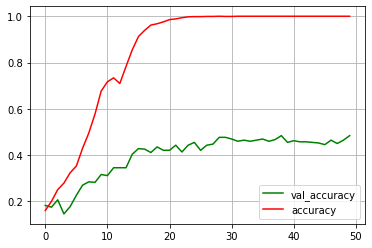

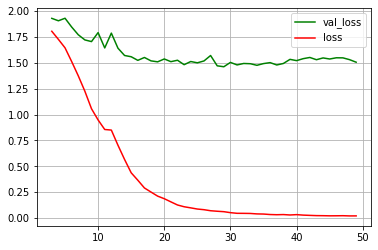

In [ ]:
""" plots """
history = pd.read_csv('../log/OtherModels/CNNLSTM_SGD_weights_16batch_pixels.log', sep=',')
history[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid()
history[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Loading best weights
model_lstm = keras.models.load_model('../weights/OtherModels/CNNLSTM_SGD_weights_16batch_pixels.hdf5')

# Predicting on test set
y_pred = model_lstm.predict(X_test_pixels)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test, y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.57      0.66      0.61        56
   bad_back_warp       0.35      0.39      0.37        59
        bad_head       0.51      0.52      0.51        54
bad_innner_thigh       0.53      0.45      0.48        47
     bad_shallow       0.74      0.72      0.73        68
         bad_toe       0.64      0.52      0.57        71
            good       0.44      0.48      0.46        56

        accuracy                           0.54       411
       macro avg       0.54      0.53      0.53       411
    weighted avg       0.55      0.54      0.54       411



---
<a id=nonormalization></a> 
# The ResNet without any kind of normalization

The versions of the *ResNet* model under this section take as an input the arrays derived from the post-processed distance matrices. These matrices - as we have already seen - have been adjusted to deal with the problem of undetected keypoints, wrong swap between the right and left part, and shaky coordinates coming from un-natural movements. Therefore the starting point for our *ResNet* is represented by these swapped and smoothed arrays of distance values. \
In this part of the notebook we just consider the dataset without any kind of normalization. Indeed our goal is to start from un-normalized input and then to see if the addition of normalization can improve the generalization of our classification model. 

Let's now describe the parameters we chose for the *ResNet* given the unnormalized input. \
The several versions of the model are characterized by differences on the number of batch size and on the choice of the optimizer. \

Regarding the **batch size**, originally we set it to 64 but our model was struggling to learn and, given the low accuracy on both the development and test set, we decided to lower it. Therefore here we firstly set batch_size  to 32, which is in general a good starting point, and then we tried to lower this value to see if the performance of our model would improve. The switch from 64 to 32 improved significantly the testing accuracy. Indeed, we went from about 48% to over 80% (the actual value depends on the optimizer). On the other hand, the change in performance between 32 and 16 depends on the optimizer we use. Indeed, the testing accuracy can increase in the case of the adam optimizer, or decrease slightly in the case of sgd.\

As for the **number of epochs**, we set it initially to 100. Our goal was to choose a pretty high value so as to have a general overview of the loss behaviour. In almost all situations (with exception of when the *Adadelta optimizer* is used), as we can see in the plots below, the validation loss curve is quite wiggly. It keeps fluctuating, without converging to an evident minimum neither following a clear pattern.\
Therefore, the fluctuating behavior of this instable validation loss also prevents us from using the *Early Stopping callback*, that - even with the patience parameter set to 3 - will make the training stop running just after few epochs when the validation/testing accuracies are still too low with respect to the potential level they could reach.
For this reason, after having tried the *EarlyStopping*, we have decided not to include it as a way of choosing which epoch to retrieve the weights from.\

Instead, we have preferred relying on the **Method-CheckPoint callback**, that allows to save the weights of the best epoch  without stopping the training. For the definition of 'best' we monitored the validation accuracy.\
Indeed, the role of the **validation set** is to let us understand how the model is able to generalize to unseen data. Since we want to deploy our solution to new video materials, we care about being able to generalize results. For this reason, we track the weight connected to the epoch in which the validation accuracy is the highest. To avoid overfitting on the val set (i.e. having good accuracy on the val set, but not on the test set) and, thus, being bot able to generalize results on the test set, we also shuffle the videos, to include all categories of squats, and we set the test-set to 20% of our dataset, in order for it not to be too small.\

Besides, we also tested different types of **optimizers**.
We started from the most common one, the *adam optimizer* and then we tried the *stochastic gradient descent* and the *AdaDelta*. The *SGD* outperforms the others while the *AdaDelta* is significantly worse than its fellows.\
\
Below, you can find all the various versions we implemented, with related plots and classification reports.
We will provide detailed comments only for the best version's results.








In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(arrayX, arrayY)

<a id=adam></a> 
## Adam Optimizer 


<a id=32adam></a> 
### Adam Optimizer with batch size 32


In [ ]:
# Initalizing the model
model = create_res_net('adam')
batch_size = 32 
epochs = 100 

# With this callback we save the weights of the best epoch based on val_accuracy
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/adam32_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model.fit(X_train, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model.evaluate(X_test, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/training32batch_nonormsklearn100.csv', index=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
39/39 - 29s - loss: 2.9581 - accuracy: 0.2086 - val_loss: 8236249.0000 - val_accuracy: 0.1338
Epoch 2/100
39/39 - 27s - loss: 1.7701 - accuracy: 0.3742 - val_loss: 5830.2891 - val_accuracy: 0.1411
Epoch 3/100
39/39 - 26s - loss: 1.6472 - accuracy: 0.3994 - val_loss: 24.6176 - val_accuracy: 0.1192
Epoch 4/100
39/39 - 28s - loss: 1.5082 - accuracy: 0.4529 - val_loss: 8.5735 - val_accuracy: 0.2019
Epoch 5/100
39/39 - 27s - loss: 1.2637 - accuracy: 0.5390 - val_loss: 19.8503 - val_accuracy: 0.1460
Epoch 6/100
39/39 - 27s - loss: 1.3839 - accuracy: 0.5260 - val_loss: 31.4456 - val_accuracy: 0.1460
Epoch 7/100
39/39 - 27s - loss: 1.0382 - accuracy: 0.6177 - val_loss: 17.0802 - val_accuracy: 0.1825
Epoch 8/100
39/39 - 27s - loss: 1.0785 - accuracy: 0.6315 - val_loss: 4.3518 - val_accuracy: 0.3163
Epoch 9/100
39/39 - 27s - loss: 0.8242 - accuracy: 0.6891 - val_loss: 2.4583 - val_accuracy: 0.4842
Epoch 10/100
39/39 - 27s - loss: 0.7470 - accuracy: 0.7305 - val_loss: 6.4849 - val_acc

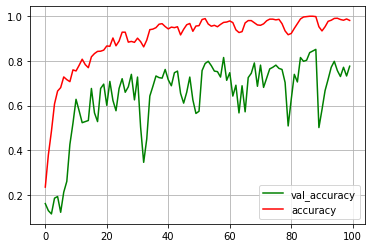

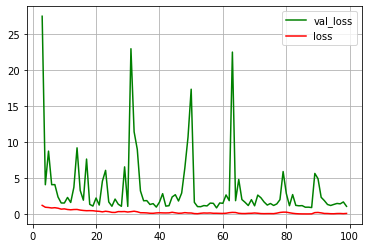

In [ ]:
history = pd.read_csv('../log/training32batch_nonormsklearn100.csv', sep=',')
history[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
history[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# The best epoch whose weigths we retrieve from is the 85th with a val_accuracy 
# of 85% and a val loss of 0.97
model.load_weights('../weights/adam32_weights.87-0.97.hdf5')

# Prediction on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.88      0.88      0.88        56
   bad_back_warp       0.79      0.83      0.81        59
        bad_head       0.63      0.54      0.58        54
bad_innner_thigh       0.79      0.87      0.83        47
     bad_shallow       0.86      0.96      0.90        68
         bad_toe       0.88      0.75      0.81        71
            good       0.75      0.79      0.77        56

        accuracy                           0.80       411
       macro avg       0.80      0.80      0.80       411
    weighted avg       0.80      0.80      0.80       411



<a id=16adam></a> 
### Adam Optimizer with batch size 16


In [ ]:
# Initalizing the model
model2 = create_res_net('adam')
batch_size = 16
epochs = 100 

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/adam16_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model2.fit(X_train, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val), 
          callbacks=[model_checkpoint_callback])

df = pd.DataFrame(history.history)
df.to_csv('../log/training16batch_nonormsklearn100.csv', index=False)

loss, accuracy = model2.evaluate(X_test, y_test,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
77/77 - 15s - loss: 2.8256 - accuracy: 0.2216 - val_loss: 118.9790 - val_accuracy: 0.1582
Epoch 2/100
77/77 - 13s - loss: 2.0395 - accuracy: 0.3125 - val_loss: 27.9359 - val_accuracy: 0.1484
Epoch 3/100
77/77 - 14s - loss: 1.8748 - accuracy: 0.3726 - val_loss: 8.1837 - val_accuracy: 0.1995
Epoch 4/100
77/77 - 14s - loss: 1.5001 - accuracy: 0.4521 - val_loss: 45.7929 - val_accuracy: 0.1557
Epoch 5/100
77/77 - 14s - loss: 1.1729 - accuracy: 0.5942 - val_loss: 5.6566 - val_accuracy: 0.3066
Epoch 6/100
77/77 - 14s - loss: 1.2213 - accuracy: 0.5795 - val_loss: 2.0053 - val_accuracy: 0.4866
Epoch 7/100
77/77 - 14s - loss: 0.9722 - accuracy: 0.6534 - val_loss: 1.5066 - val_accuracy: 0.6229
Epoch 8/100
77/77 - 14s - loss: 0.8363 - accuracy: 0.6981 - val_loss: 1.2203 - val_accuracy: 0.6326
Epoch 9/100
77/77 - 13s - loss: 0.7418 - accuracy: 0.7232 - val_loss: 1.6434 - val_accuracy: 0.5961
Epoch 10/100
77/77 - 14s - loss: 0.7083 - accuracy: 0.7378 - val_loss: 1.2242 - val_accuracy: 0.

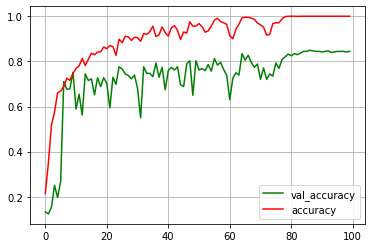

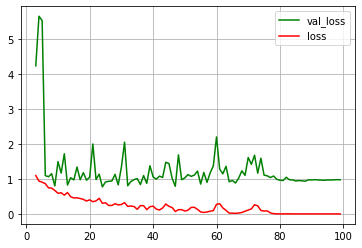

In [ ]:
history = pd.read_table('../log/training16batch_nonormsklearn100.csv', sep=',')
history[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
history[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Best epoch for val accuracy is the 100th with validation loss of 0.81 and 
# validation accuracy of 82%
model2.load_weights('../weights/adam16_weights.100-0.81.hdf5')

# Prediction on the test set
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.89      0.86      0.87        56
   bad_back_warp       0.81      0.86      0.84        59
        bad_head       0.68      0.52      0.59        54
bad_innner_thigh       0.85      0.87      0.86        47
     bad_shallow       0.82      0.96      0.88        68
         bad_toe       0.90      0.77      0.83        71
            good       0.66      0.77      0.71        56

        accuracy                           0.81       411
       macro avg       0.80      0.80      0.80       411
    weighted avg       0.81      0.81      0.80       411



<a id=sgd></a> 
## Stochastic Gradient Descent

<a id=32sgd></a> 
### Stochastic Gradient Descent with batch size 32


**This version of the model can be considered the best among all the others**. \
The test accuracy reached in the epoch where the validation accuracy peaks is equal to 85%. 
By analyzing the plots, it is evident that the model is able to learn pretty quickly. \
Indeed, after just the first 15 epochs, both the val accuracy and the loss accuracy have increased/decreased significantly and have reached the level around which they will keep moving until the last epoch. 


For this reason, retrieving the weights from the best epoch and printing the test results given these weights would not be essential ( i.e. choosing a precise epoch is not so significant, since with either the 32th and the 90th epoch, for example, we would get similar validation accuracy scores). \
However, we did it regardless, to have a clear picture of the most we could get, in term of validation and testing accuracy, and also to avoid the consistent drop/raise of the validation accuracy/loss towards the final epochs (as resembled in the plots below, just before the 80th epoch).



In [ ]:
#Initalizing the model
model_s = create_res_net('sgd')
batch_size = 32
epochs = 100 

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/sgd32_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model_s.fit(X_train, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val), 
          callbacks=[model_checkpoint_callback])


loss, accuracy = model_s.evaluate(X_test, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/training32batch_nonormsklearn_SGD.csv', index=False)

Epoch 1/100
39/39 - 13s - loss: 2.1415 - accuracy: 0.2330 - val_loss: 5.6997 - val_accuracy: 0.1484
Epoch 2/100
39/39 - 13s - loss: 1.7760 - accuracy: 0.3466 - val_loss: 1.9064 - val_accuracy: 0.1971
Epoch 3/100
39/39 - 13s - loss: 1.3012 - accuracy: 0.5000 - val_loss: 2.0787 - val_accuracy: 0.1752
Epoch 4/100
39/39 - 13s - loss: 0.9956 - accuracy: 0.6161 - val_loss: 2.3262 - val_accuracy: 0.1873
Epoch 5/100
39/39 - 13s - loss: 0.7514 - accuracy: 0.7192 - val_loss: 2.4398 - val_accuracy: 0.1922
Epoch 6/100
39/39 - 13s - loss: 0.4832 - accuracy: 0.8369 - val_loss: 3.0153 - val_accuracy: 0.2019
Epoch 7/100
39/39 - 13s - loss: 0.3305 - accuracy: 0.9075 - val_loss: 2.4637 - val_accuracy: 0.2506
Epoch 8/100
39/39 - 13s - loss: 0.2323 - accuracy: 0.9448 - val_loss: 2.0870 - val_accuracy: 0.3163
Epoch 9/100
39/39 - 13s - loss: 0.1290 - accuracy: 0.9789 - val_loss: 2.0810 - val_accuracy: 0.3942
Epoch 10/100
39/39 - 13s - loss: 0.0932 - accuracy: 0.9870 - val_loss: 1.3885 - val_accuracy: 0.5231

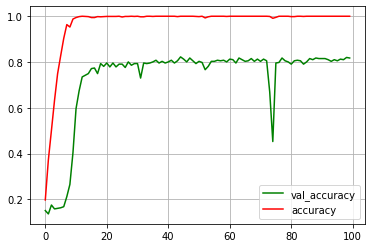

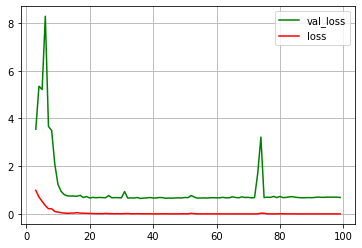

In [ ]:
history = pd.read_table('../log/training32batch_nonormsklearn_SGD.log', sep=',')
history[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
history[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Best epoch for val accuracy is the 26th with  val loss = 0.61 and val accuracy = 82,73%
model_s.load_weights('../weights/sgd32_weights.26-0.61.hdf5')

# Prediction on the test set
y_pred = model_s.predict(X_test)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.87      0.93      0.90        56
   bad_back_warp       0.84      0.83      0.84        59
        bad_head       0.74      0.63      0.68        54
bad_innner_thigh       0.90      0.94      0.92        47
     bad_shallow       0.94      0.94      0.94        68
         bad_toe       0.90      0.86      0.88        71
            good       0.74      0.82      0.78        56

        accuracy                           0.85       411
       macro avg       0.85      0.85      0.85       411
    weighted avg       0.85      0.85      0.85       411



****comment****


    If we review carefully the classification report, what we can conclude is that the high general accuracy is confirmed in almost all classes. 
    Indeed, f-1 score exceeds the 84% in all cases, except for the labels bad_head and good classes.
    The bad-head class is characterized by a low recall (given the average), meaning that a significant portion of this category squats have not been correctly recognized. 
    On the other hand, if we focus on the good class, the first thing that jumps out is the not particularly satisfying precision value (74%): 82% of the good squats have been recognized, however the model has mistakenly assigned the good label to badly performed squats several times.
    By joining the two last considerations, we understand that in many cases a bad-head squat has been assigned to the good label. After having watched videos belonging to the category bad-head, the poor predictive behavior becomes clearer: in those videos the limbs movement is correct, and the only body part that is wrongly positioned is the head. In a correct exercies an individual should be looking in front of him, whereas in the bad-head category the individual looks upwards. 
    However, our 2d pose estimation does not detect the position of the eyes, thus when the head movement is not very marked, it fails to detect where the individual is looking at, resulting in classifying the exercise as good, since the general movement is correct.  
    As we will discuss in [Section 2.5](#section_id) of our work, in which we implement a test of this hypothesis, this trend is present in all the results of our classifiers.

<a id=16sgd></a> 
### Stochastic Gradient Descent with batch_size 16

In [ ]:
model_s2 = create_res_net('sgd')
batch_size = 16
epochs = 100 

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/sgd16_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model_s2.fit(X_train, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_s2.evaluate(X_test, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/training16batch_nonormsklearn_SGD.csv', index=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
77/77 - 14s - loss: 2.1773 - accuracy: 0.2305 - val_loss: 2.1017 - val_accuracy: 0.1606
Epoch 2/100
77/77 - 13s - loss: 1.6325 - accuracy: 0.3864 - val_loss: 3.0319 - val_accuracy: 0.1582
Epoch 3/100
77/77 - 14s - loss: 1.2106 - accuracy: 0.5479 - val_loss: 2.0065 - val_accuracy: 0.2482
Epoch 4/100
77/77 - 14s - loss: 0.9040 - accuracy: 0.6688 - val_loss: 1.4990 - val_accuracy: 0.4501
Epoch 5/100
77/77 - 13s - loss: 0.6568 - accuracy: 0.7760 - val_loss: 2.1463 - val_accuracy: 0.3309
Epoch 6/100
77/77 - 14s - loss: 0.4538 - accuracy: 0.8490 - val_loss: 0.9605 - val_accuracy: 0.6521
Epoch 7/100
77/77 - 14s - loss: 0.2921 - accuracy: 0.9123 - val_loss: 0.8020 - val_accuracy: 0.7275
Epoch 8/100
77/77 - 13s - loss: 0.2049 - accuracy: 0.9464 - val_loss: 1.0036 - val_accuracy: 0.6569
Epoch 9/100
77/77 - 13s - loss: 0.1792 - accuracy: 0.9529 - val_loss: 0.9126 - val_accuracy: 0.6959
Epoch 10/100
77/77 - 14s - loss: 0.1198 - accuracy: 0.9748 - val_loss: 0.6634 - val_accuracy: 0.8005

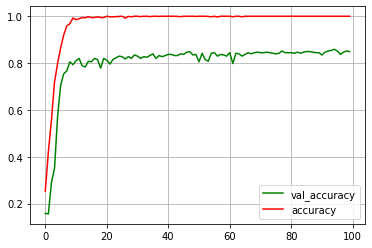

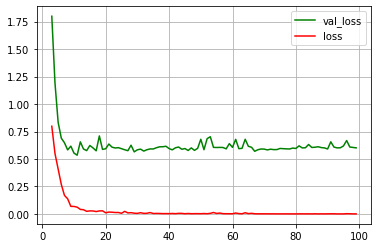

In [ ]:
history = pd.read_table('../log/training16batch_nonormsklearn_SGD.log', sep=',')
history[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
history[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Best epoch for val accuracy is the 95th with validation loss = 0.67 and 
# validation accuracy = 83,45%
model_s2.load_weights('../weights/sgd16_weights.95-0.67.hdf5')

# Prediction on the test set
y_pred = model_s2.predict(X_test)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.83      0.88      0.85        56
   bad_back_warp       0.73      0.83      0.78        59
        bad_head       0.80      0.61      0.69        54
bad_innner_thigh       0.91      0.87      0.89        47
     bad_shallow       0.91      0.99      0.94        68
         bad_toe       0.95      0.85      0.90        71
            good       0.77      0.86      0.81        56

        accuracy                           0.84       411
       macro avg       0.84      0.84      0.84       411
    weighted avg       0.85      0.84      0.84       411



<a id=AdaDelta></a> 
## Ada Delta optimizer


In this case we did not try several values for the batch size parameter since we have immediately notice that this optimizer cannot compete with the other two, at least in our setting. This optimizer is the one used in Ogata et al. (2019).

In [ ]:
model_a = create_res_net('Adadelta')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/AdaDelta32_weights.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

batch_size = 32 
epochs = 100 

history = model_a.fit(X_train, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_a.evaluate(X_test, y_test,
                                batch_size=batch_size,
                                verbose=False)


df = pd.DataFrame(history.history)
df.to_csv('../log/trainingAdaDelta32_weights.csv', index=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
39/39 - 30s - loss: 2.0594 - accuracy: 0.1437 - val_loss: 1.9871 - val_accuracy: 0.1290
Epoch 2/100
39/39 - 28s - loss: 1.9735 - accuracy: 0.1583 - val_loss: 2.0266 - val_accuracy: 0.1192
Epoch 3/100
39/39 - 27s - loss: 1.9168 - accuracy: 0.1956 - val_loss: 2.0638 - val_accuracy: 0.1192
Epoch 4/100
39/39 - 27s - loss: 1.8869 - accuracy: 0.2135 - val_loss: 2.0992 - val_accuracy: 0.1192
Epoch 5/100
39/39 - 28s - loss: 1.8525 - accuracy: 0.2297 - val_loss: 2.1209 - val_accuracy: 0.1411
Epoch 6/100
39/39 - 27s - loss: 1.8212 - accuracy: 0.2711 - val_loss: 2.1236 - val_accuracy: 0.1290
Epoch 7/100
39/39 - 27s - loss: 1.7811 - accuracy: 0.3109 - val_loss: 2.0984 - val_accuracy: 0.1168
Epoch 8/100
39/39 - 27s - loss: 1.7671 - accuracy: 0.3149 - val_loss: 2.0769 - val_accuracy: 0.1338
Epoch 9/100
39/39 - 28s - loss: 1.7345 - accuracy: 0.3474 - val_loss: 2.0607 - val_accuracy: 0.1436
Epoch 10/100
39/39 - 27s - loss: 1.6981 - accuracy: 0.3774 - val_loss: 2.0382 - val_accuracy: 0.1290

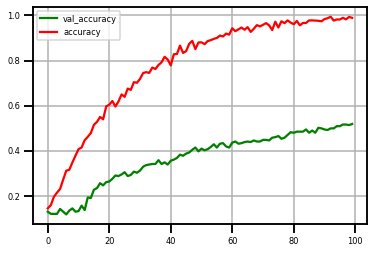

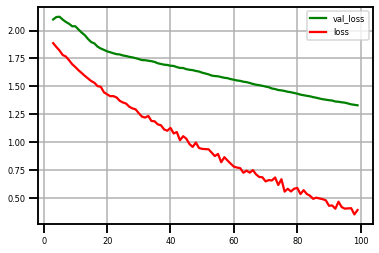

In [ ]:
history = pd.read_csv('../log/trainingAdaDelta32_weights.csv', sep=',')
history[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
history[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
model_a.load_weights('../weights/AdaDelta32_weights.hdf5')

# Prediction on the test set
y_pred = model_a.predict(X_test)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.69      0.71      0.70        56
   bad_back_warp       0.47      0.44      0.46        59
        bad_head       0.39      0.44      0.42        54
bad_innner_thigh       0.56      0.47      0.51        47
     bad_shallow       0.68      0.84      0.75        68
         bad_toe       0.58      0.41      0.48        71
            good       0.47      0.54      0.50        56

        accuracy                           0.55       411
       macro avg       0.55      0.55      0.55       411
    weighted avg       0.55      0.55      0.55       411



<a id=bootstrap></a> 
## Significance testing: Bootstrap technique

 

Once the *AdaDelta optimizer* has been put aside, we proceed in comparing the *ResNet* with the *adam optimizer* and the *Resnet* with *Sgd optimizer* by using the **bootstrap technique**. \
Indeed, we have observed that both the *adam optimizer* and the *sgd* one allow the model to reach very good results in term of accuracy, with the latter however predominating over the former.  \

With this technique, we investigate whether the difference observed in validation and testing accuraces between these two optimizers in our dataset can be generalizable to other datasets. 
To address this concern the best way would be to directly test on new data. However, in the absence of other samples, as in this case, it is possible to approximate the effect by simulations. So, we compare the two models on subsets of the test set, collected by repeatedly sampling with replacement, and we record when the difference in performance between the two models is more extreme than on the full data. \
The result obtained tell us that the difference observed between the *Resnet* with the *adam optimizer* and the *Sgd* is not significant.

In [ ]:
from sklearn.metrics import accuracy_score

def bootstrap_sample(system1, system2, gold, samples=1000, 
                     score=accuracy_score):
    """
    compute the proportion of times that the performance difference of the two 
    implementations, on a subsample, is significantly different from the   
    performance on the entire sample
    """
    N = len(gold) # Number of instances
    
    # Make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # Compute performance score on entire sample
    base_score1 = score(gold, system1)
    base_score2 = score(gold, system2)
    
    # Switch systems if system2 is better 
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # Compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # Select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # Collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # Compute scores on subsample
        sample_score1 = score(gold_sample, sample1)
        sample_score2 = score(gold_sample, sample2)
        sample_delta = sample_score1 - sample_score2

        # Check whether the observed sample difference is at least twice as
        # large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

In [ ]:
# Comparing the two versions of the model on the test set.
# The performance difference results not to be significant
y_pred = model.predict(X_test) #32 Adam
y_pred_adam = np.argmax(y_pred, axis =1)

y_pred = model_s.predict(X_test) #32 SGD
y_pred_stoc = np.argmax(y_pred, axis =1)

p_value, deltas = bootstrap_sample(y_pred_adam, y_pred_stoc, y_test)
print(p_value, p_value < 0.01)

0.096 False


In [ ]:
# Same as above but changing batch size. 
# Again, the performance difference results not to be significant
y_pred = model2.predict(X_test) #16 Adam
y_pred_adam = np.argmax(y_pred, axis =1)

y_pred = model_s2.predict(X_test) #16 SGD
y_pred_stoc = np.argmax(y_pred, axis =1)

p_value, deltas = bootstrap_sample(y_pred_adam, y_pred_stoc, y_test)
print(p_value, p_value < 0.01)

0.045 False


<a id=head></a> 
## Dropping bad_head

<a id='section_id'></a>
By analyzing the classification reports produced, an element worth noticing - trasversal to all the versions implemented - is that our model struggles with the class **bad_head**. This means that our classification model is not able to classify correctly all those videos where the individual executes the squat exercise by moving the head in a bad way (it is turned upwards). \

Under-average values for recall, precision and f-1 score within this class are not surprising. Indeed, our pose estimator, through which we built the skeleton of the individuals performing the squats and got the body keypoints' coordinates, produced just one coordinate head-related. From one 2D coordinate it is really difficult to detect this wrong position except when the movement is very marked. This results in classifying numerous of the bad head squats as good, since the limbs movement is correct. \

For this section only, we have decided to try dropping the above-mentioned class and seeing what happens to the scores of the good squats. \
We are aware of the fact that dropping all the units belonging to a given class is a bit drastic. Nonetheless, what we are going to do in the next few cells is just a temporary test, before returning to the original classification problem.
We are curious of 'testing' our hypothesis according to which many bad-head squats are not recognized - and consequently considered as good - because the pose estimator we relied on does not have enough reference points to establish whether the head is well positioned.

In [ ]:
# Creating the drop_head dataset
X_train_drop_head = X_train[np.where(y_train!=2)]
y_train_drop_head = y_train[np.where(y_train!=2)]
X_val_drop_head = X_val[np.where(y_val!=2)]
y_val_drop_head = y_val[np.where(y_val!=2)]
X_test_drop_head = X_test[np.where(y_test!=2)]
y_test_drop_head = y_test[np.where(y_test!=2)]

y_train_drop_head[y_train_drop_head ==6] = 2
y_test_drop_head[y_test_drop_head ==6] = 2
y_val_drop_head[y_val_drop_head ==6] = 2

In [ ]:
# Initalizing the model
model_d = create_res_net('SGD')
batch_size = 32
epochs = 100 

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/32batch_SGD_nobadhad.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model_d.fit(X_train_drop_head, 
          y_train_drop_head,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val_drop_head, y_val_drop_head), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_d.evaluate(X_test_drop_head, y_test_drop_head,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/32batch_SGD_nobadhad.csv', index=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
33/33 - 23s - loss: 2.0077 - accuracy: 0.2528 - val_loss: 1.9455 - val_accuracy: 0.1551
Epoch 2/100
33/33 - 24s - loss: 1.5276 - accuracy: 0.4157 - val_loss: 1.9748 - val_accuracy: 0.1579
Epoch 3/100
33/33 - 23s - loss: 1.1160 - accuracy: 0.5748 - val_loss: 2.1414 - val_accuracy: 0.1524
Epoch 4/100
33/33 - 23s - loss: 0.7717 - accuracy: 0.7206 - val_loss: 2.1950 - val_accuracy: 0.1524
Epoch 5/100
33/33 - 23s - loss: 0.5250 - accuracy: 0.8163 - val_loss: 2.1861 - val_accuracy: 0.1524
Epoch 6/100
33/33 - 24s - loss: 0.3643 - accuracy: 0.8892 - val_loss: 1.9357 - val_accuracy: 0.2078
Epoch 7/100
33/33 - 24s - loss: 0.1815 - accuracy: 0.9602 - val_loss: 1.8174 - val_accuracy: 0.3241
Epoch 8/100
33/33 - 23s - loss: 0.1100 - accuracy: 0.9858 - val_loss: 1.8633 - val_accuracy: 0.3075
Epoch 9/100
33/33 - 23s - loss: 0.0644 - accuracy: 0.9972 - val_loss: 1.8583 - val_accuracy: 0.3186
Epoch 10/100
33/33 - 24s - loss: 0.0474 - accuracy: 0.9962 - val_loss: 1.7643 - val_accuracy: 0.4432

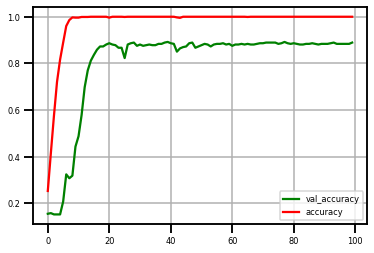

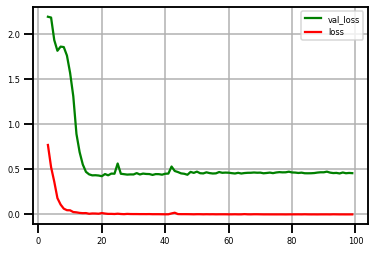

In [ ]:
history = pd.read_table('../log/32batch_SGD_nobadhad.csv', sep=',')
history[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid()
history[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Best weights retrive form best epoch for val accuracy 
classes_dropped = ['bad_back_round', 'bad_back_warp', 'good',
                   'bad_innner_thigh','bad_shallow', 'bad_toe']

model_d.load_weights('../weights/32batch_SGD_nobadhad.hdf5')

# Prediction on the test set
y_pred = model_d.predict(X_test_drop_head)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test_drop_head, y_pred, target_names=classes_dropped))

                  precision    recall  f1-score   support

  bad_back_round       0.85      0.84      0.85        56
   bad_back_warp       0.86      0.85      0.85        59
            good       0.85      0.93      0.89        56
bad_innner_thigh       1.00      0.94      0.97        47
     bad_shallow       0.93      0.97      0.95        68
         bad_toe       0.93      0.89      0.91        71

        accuracy                           0.90       357
       macro avg       0.90      0.90      0.90       357
    weighted avg       0.90      0.90      0.90       357



****Comment**** 

    Without the bad-head class, the well performed squat keeps up with the other labels' performance. 
    The precision has increased, since the model does not assign incorrectly this label to the bad-head squats anymore.
    Our hypothesis has been proven correct. 

<a id=normalization></a> 
# The ResNet with normalization

In the following section, we run our classification model starting from normalized input. \
A detailed description of these normalizations can be found in 
Section 1.4.  in the Notebook `2_OpenPose_Postprocessing.ipynb`.

*PLEASE NOTE:* \
*From the bootstrap test we conclude that there is no statistical difference between the performance of the Adam and SGD models. However, the SGD version is less wiggly in the training phase compared to the Adam version and it provided more consistent results between epochs. For this reason we will use the ResNet with SGD optimizer and batch size equals to 32 for the comparisons between un-normalized input versus normalized input.*

<a id=norm1></a> 
## Normalization of type 1
With the first normalization, through which we rescaled all body distances by the **length of the torso**, our classification model should become able to classifly correctly even those squat exercises performed by different individual who hence have different physical structures. \

This is not fundamental for our specific dataset because all the squats are made by the same individual. However, it is required for the generalization of our model, i.e. to make it applicable to any kind of athlete's body shape. \
In conclusion, we do not expect to have a significant improvement in the *ResNet* performance with this dataset but we still make an attempt to see if we incur in any positive change. 
Besides, as we will see later on in the Notebook `4_Model_on_us_Argparse.ipynb`, this normalization will become extremely important once we will test and challenge our model on new videos, made by us and thus characterized by different body types. 



In [ ]:
# Importing the normalized input
arrayX_norm1 = np.load('../arrays/array_normalization1.npy')

In [ ]:
X_train_norm1, X_val_norm1, X_test_norm1, y_train, y_val, y_test = train_val_test_split(arrayX_norm1,arrayY)

### SGD optimizer with batch_size 32

If we compare the results we obtain in this case with what we got before without normalization, we realize that the **torso-normalization** does not bring any improvement. The overall test accuracy is lower (82%) and even the results within the classes do not improve, as expected. \
This kind of normalization has the purpose of making any body type difference irrelevant but its effectiveness cannot be actually tested on our dataset since it consists of a *single* individual performing squats.
Therefore, running the *ResNet* after having applied the mentioned normalization just aims at presenting you the generalizable version of our model.
The question whether the model actually accounts for different body shapes will be answered only afterwards, once we will use new videos made by us as new test units.


In [ ]:
# Initializing the model
model_norm1 = create_res_net('SGD')
batch_size = 32 
epochs = 100 

In [ ]:
# With this callback we save the weights of the best epoch in term of val_accuracy
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/training32batch_standSGD_norm1.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model_norm1.fit(X_train_norm1, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val_norm1, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_norm1.evaluate(X_test_norm1, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/training32batch_standSGD_norm1.csv', index=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

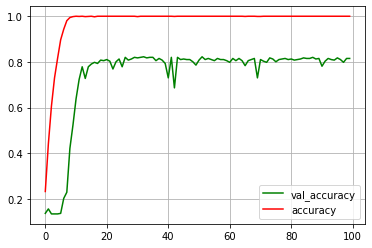

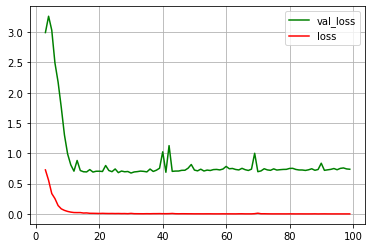

In [ ]:
history = pd.read_csv('../log/training32batch_standSGD_norm1.csv', sep=',')
history[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
history[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Retrieve the best epoch from the validation accuracy
model_norm1.load_weights('../weights/training32batch_standSGD_norm1.hdf5')

# Prediction on the test set
y_pred = model_norm1.predict(X_test_norm1)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.86      0.89      0.88        56
   bad_back_warp       0.77      0.81      0.79        59
        bad_head       0.74      0.59      0.66        54
bad_innner_thigh       0.91      0.87      0.89        47
     bad_shallow       0.88      0.96      0.92        68
         bad_toe       0.89      0.83      0.86        71
            good       0.67      0.75      0.71        56

        accuracy                           0.82       411
       macro avg       0.82      0.82      0.81       411
    weighted avg       0.82      0.82      0.82       411



<a id=norm2></a> 
## Normalization type 2

With this second normalization, we have rescaled all the values of the distance matrices to end up having everything within the [0,1] range.
This normalization might help the classification model because dealing with lower numbers should be easier. 

In [ ]:
# Loading Normalization2 Array
arrayX_norm2 = np.load('../arrays/array_normalization2.npy')

# Splitting again into train val test
X_train_norm2, X_val_norm2, X_test_norm2, y_train, y_val, y_test = train_val_test_split(arrayX_norm2, arrayY)

### SGD optimizer with batch_size 32

If we look at the following results, we conclude that even this second normalization does not improve our classification model.\
However, differently from the first normalization,
this is a bit unexpected. 
Since we have expressed all the distances in a [0,1] range, we would expect to get better results.
Instead, the test accuracy has remained the same.
One possible explanation could be that our model already performed well (also before, it reached 1 in accuracy in the training set) and rescaling all the values did not make any difference.




In [ ]:
# Initalizing the model
model_norm2 = create_res_net('SGD')
batch_size = 32 
epochs = 100

# With this callback we save the weights of the best epoch in term of val_accuracy
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/norm2_32_weightsSGD.{epoch:02d}-{val_loss:.2f}.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model_norm2.fit(X_train_norm2, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val_norm2, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_norm2.evaluate(X_test_norm2, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/norm2_32_weightsgd.csv', index = False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
39/39 - 60s - loss: 2.1134 - accuracy: 0.2151 - val_loss: 1.9667 - val_accuracy: 0.1557
Epoch 2/100
39/39 - 53s - loss: 1.6192 - accuracy: 0.3774 - val_loss: 2.0331 - val_accuracy: 0.1557
Epoch 3/100
39/39 - 53s - loss: 1.2997 - accuracy: 0.5049 - val_loss: 2.0833 - val_accuracy: 0.1557
Epoch 4/100
39/39 - 53s - loss: 0.9853 - accuracy: 0.6282 - val_loss: 2.7375 - val_accuracy: 0.1557
Epoch 5/100
39/39 - 53s - loss: 0.6750 - accuracy: 0.7622 - val_loss: 3.4444 - val_accuracy: 0.1168
Epoch 6/100
39/39 - 53s - loss: 0.4096 - accuracy: 0.8880 - val_loss: 3.6886 - val_accuracy: 0.1192
Epoch 7/100
39/39 - 53s - loss: 0.2790 - accuracy: 0.9383 - val_loss: 4.3433 - val_accuracy: 0.1265
Epoch 8/100
39/39 - 54s - loss: 0.1670 - accuracy: 0.9732 - val_loss: 3.7879 - val_accuracy: 0.1582
Epoch 9/100
39/39 - 54s - loss: 0.1373 - accuracy: 0.9765 - val_loss: 4.6343 - val_accuracy: 0.1533
Epoch 10/100
39/39 - 54s - loss: 0.0921 - accuracy: 0.9894 - val_loss: 3.3447 - val_accuracy: 0.2165

NameError: ignored

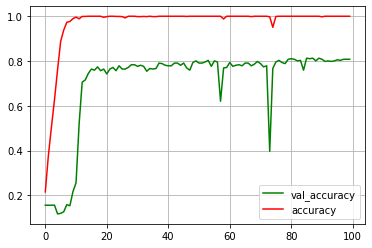

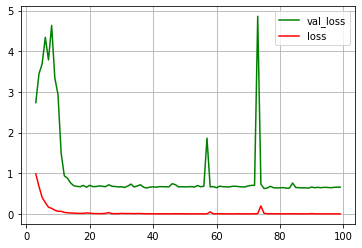

In [ ]:
df = pd.read_csv('../log/norm2_32_weightsgd.csv')
df[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
df[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Loading Best weights
model_norm2.load_weights('../weights/norm2_32_weightsSGD.86-0.65.hdf5')

# Prediction on the test set
y_pred = model_norm2.predict(X_test_norm2)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test, y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.84      0.88      0.86        56
   bad_back_warp       0.75      0.76      0.76        59
        bad_head       0.76      0.63      0.69        54
bad_innner_thigh       0.88      0.91      0.90        47
     bad_shallow       0.84      0.87      0.86        68
         bad_toe       0.85      0.79      0.82        71
            good       0.73      0.82      0.77        56

        accuracy                           0.81       411
       macro avg       0.81      0.81      0.81       411
    weighted avg       0.81      0.81      0.81       411



<a id=norm3></a> 
## Normalization type 3

With the third normalization we try to normalize each video with the dimension of a the arm (distance elbow-wrist). We believe that this is the most standard measure so normalizing with respect to this can lead to more general results on our opinion. 

In [ ]:
# Loading Normalization3 Array
arrayX_norm3 = np.load('../arrays/array_normalization3.npy')

# Splitting again into train val test
X_train_norm3, X_val_norm3, X_test_norm3, y_train, y_val, y_test = train_val_test_split(arrayX_norm3, arrayY)

In [ ]:
# Initalize the model
batch_size = 32 
epochs = 100 

model_norm3 = create_res_net('SGD')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/normWrist_SGD32.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model_norm3.fit(X_train_norm3, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val_norm3, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_norm3.evaluate(X_test_norm3, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/normWrist_SGD32.csv')

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
39/39 - 27s - loss: 2.2786 - accuracy: 0.2119 - val_loss: 1.9316 - val_accuracy: 0.1752
Epoch 2/100
39/39 - 25s - loss: 1.9407 - accuracy: 0.2727 - val_loss: 1.9957 - val_accuracy: 0.1606
Epoch 3/100
39/39 - 26s - loss: 1.6937 - accuracy: 0.3628 - val_loss: 2.2643 - val_accuracy: 0.1557
Epoch 4/100
39/39 - 28s - loss: 1.4556 - accuracy: 0.4740 - val_loss: 2.1273 - val_accuracy: 0.1825
Epoch 5/100
39/39 - 27s - loss: 1.2304 - accuracy: 0.5536 - val_loss: 3.3285 - val_accuracy: 0.1582
Epoch 6/100
39/39 - 26s - loss: 1.0139 - accuracy: 0.6096 - val_loss: 4.9815 - val_accuracy: 0.1606
Epoch 7/100
39/39 - 27s - loss: 0.8669 - accuracy: 0.6924 - val_loss: 5.4514 - val_accuracy: 0.1582
Epoch 8/100
39/39 - 27s - loss: 0.6742 - accuracy: 0.7727 - val_loss: 3.9780 - val_accuracy: 0.1825
Epoch 9/100
39/39 - 28s - loss: 0.5410 - accuracy: 0.8190 - val_loss: 4.6614 - val_accuracy: 0.1849
Epoch 10/100
39/39 - 28s - loss: 0.4599 - accuracy: 0.8547 - val_loss: 3.8236 - val_accuracy: 0.2117

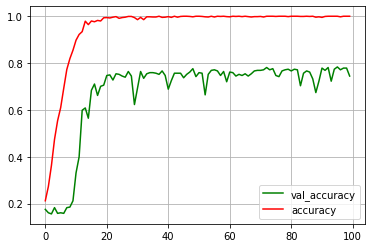

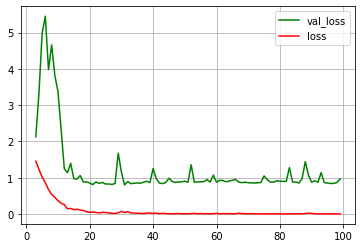

In [ ]:
df = pd.read_csv('../log/normWrist_SGD32.csv')
df[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid()
df[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Retrieve the best epoch from the val
model_norm3.load_weights('../weights/normWrist_SGD32.hdf5')

# Prediction on the test set
y_pred = model_norm3.predict(X_test_norm3)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test, y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.79      0.82      0.81        56
   bad_back_warp       0.79      0.83      0.81        59
        bad_head       0.59      0.61      0.60        54
bad_innner_thigh       0.88      0.74      0.80        47
     bad_shallow       0.85      0.93      0.89        68
         bad_toe       0.92      0.82      0.87        71
            good       0.71      0.73      0.72        56

        accuracy                           0.79       411
       macro avg       0.79      0.78      0.78       411
    weighted avg       0.80      0.79      0.79       411



<a id=appendix></a> 
# APPENDIX


<a id=newmodels></a> 
## Extra models

In this section we try different architectures to check if we can have better performances. We proposed other two sequential models: *AlexNet* and *VGG* and we implemented them on keras. Furthermore, we try a *CNN-LSTM* approach. Since our data are videos and they can be considered as a sequence of frames, we belive that this models can lead to good results.\
We train all these models using the un-normalized version of our data.


<a id=alexnet></a> 
### AlexNet 
Here we implement the *AlexNet* architecture on keras and we trained it with both adam and sgd optmizers with batch size equal to 16.\
The model is quite fast and it performs well. However, it doesn't carry out better result compared to the *ResNet*.

#### Adam 16 batch

In [ ]:
# Initalizing the model
model_alex_a = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(105,150,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model_alex_a.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
batch_size = 16 
epochs = 250 

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/OtherModels/AlexNet_adam_weights_16batch.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model_alex_a.fit(X_train, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_alex_a.evaluate(X_test, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/OtherModels/AlexNet_adam_weights_16batch.csv')

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/250
77/77 - 2s - loss: 3.6662 - accuracy: 0.1989 - val_loss: 3.6449 - val_accuracy: 0.2044
Epoch 2/250
77/77 - 1s - loss: 1.7893 - accuracy: 0.3117 - val_loss: 2.0776 - val_accuracy: 0.1849
Epoch 3/250
77/77 - 2s - loss: 1.6962 - accuracy: 0.3287 - val_loss: 2.0418 - val_accuracy: 0.2311
Epoch 4/250
77/77 - 2s - loss: 1.5485 - accuracy: 0.3839 - val_loss: 2.0367 - val_accuracy: 0.2968
Epoch 5/250
77/77 - 2s - loss: 1.4786 - accuracy: 0.4075 - val_loss: 1.4030 - val_accuracy: 0.4428
Epoch 6/250
77/77 - 1s - loss: 1.3753 - accuracy: 0.4675 - val_loss: 1.6383 - val_accuracy: 0.3650
Epoch 7/250
77/77 - 1s - loss: 1.4838 - accuracy: 0.4221 - val_loss: 2.7274 - val_accuracy: 0.2871
Epoch 8/250
77/77 - 1s - loss: 1.3389 - accuracy: 0.4724 - val_loss: 1.5972 - val_accuracy: 0.3674
Epoch 9/250
77/77 - 2s - loss: 1.2709 - accuracy: 0.5016 - val_loss: 1.2782 - val_accuracy: 0.5426
Epoch 10/250
77/77 - 1s - loss: 1.2673 - accuracy: 0.4919 - val_loss: 1.3080 - val_accuracy: 0.4720
Epoch 11/

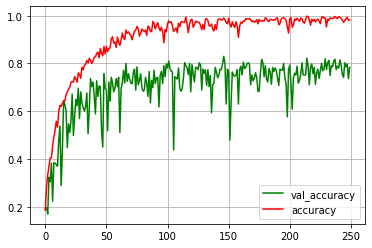

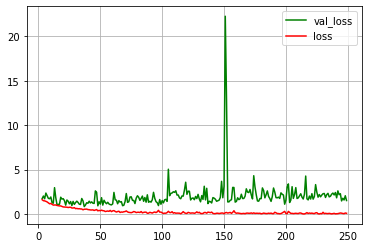

In [ ]:
df = pd.read_csv('../log/OtherModels/AlexNet_adam_weights_16batch.csv')
df[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid()
df[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Retrieve the best epoch from the val
model_alex_a.load_weights('../weights/OtherModels/AlexNet_adam_weights_16batch.hdf5')

# Prediction on the test set
y_pred = model_alex_a.predict(X_test)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.96      0.86      0.91        56
   bad_back_warp       0.83      0.83      0.83        59
        bad_head       0.68      0.63      0.65        54
bad_innner_thigh       0.81      0.72      0.76        47
     bad_shallow       0.80      0.94      0.86        68
         bad_toe       0.92      0.86      0.89        71
            good       0.73      0.84      0.78        56

        accuracy                           0.82       411
       macro avg       0.82      0.81      0.81       411
    weighted avg       0.82      0.82      0.82       411



#### SGD 16 batch

In [ ]:
# AlexNet with SGD
model_alex_s = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(105,150,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model_alex_s.compile(optimizer='SGD',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
batch_size = 16 
epochs = 250 

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/OtherModels/AlexNet_SGD_weights_16batch.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_alex_s.fit(X_train, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_alex_s.evaluate(X_test, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/OtherModels/AlexNet_16batch_SGD_250.csv')

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/250
77/77 - 2s - loss: 3.2494 - accuracy: 0.1875 - val_loss: 3.5520 - val_accuracy: 0.1338
Epoch 2/250
77/77 - 1s - loss: 2.1205 - accuracy: 0.2549 - val_loss: 1.8398 - val_accuracy: 0.3114
Epoch 3/250
77/77 - 1s - loss: 1.8053 - accuracy: 0.3182 - val_loss: 1.6947 - val_accuracy: 0.3187
Epoch 4/250
77/77 - 1s - loss: 1.6349 - accuracy: 0.3588 - val_loss: 1.4661 - val_accuracy: 0.4015
Epoch 5/250
77/77 - 1s - loss: 1.5294 - accuracy: 0.4067 - val_loss: 1.4890 - val_accuracy: 0.3990
Epoch 6/250
77/77 - 1s - loss: 1.4715 - accuracy: 0.4213 - val_loss: 1.3138 - val_accuracy: 0.4988
Epoch 7/250
77/77 - 1s - loss: 1.3536 - accuracy: 0.4700 - val_loss: 2.3004 - val_accuracy: 0.1995
Epoch 8/250
77/77 - 1s - loss: 1.2936 - accuracy: 0.4903 - val_loss: 1.1962 - val_accuracy: 0.5499
Epoch 9/250
77/77 - 1s - loss: 1.1779 - accuracy: 0.5511 - val_loss: 1.9321 - val_accuracy: 0.3309
Epoch 10/250
77/77 - 1s - loss: 1.1533 - accuracy: 0.5528 - val_loss: 1.1974 - val_accuracy: 0.5231
Epoch 11/

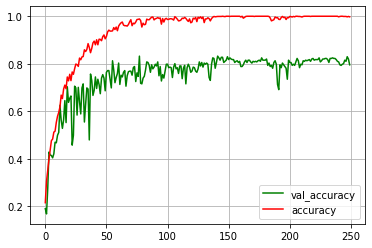

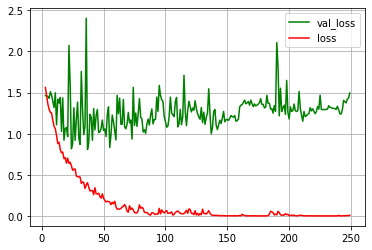

In [ ]:
df = pd.read_csv('../log/OtherModels/AlexNet_16batch_SGD_250.csv', sep=',')
df[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
df[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Retrieve the best epoch from the val
model_alex_s.load_weights('../weights/OtherModels/AlexNet_SGD_weights_16batch.hdf5')

# Prediction on the test set
y_pred = model_alex_s.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.86      0.79      0.82        56
   bad_back_warp       0.70      0.85      0.77        59
        bad_head       0.78      0.65      0.71        54
bad_innner_thigh       0.83      0.81      0.82        47
     bad_shallow       0.88      0.96      0.92        68
         bad_toe       0.95      0.85      0.90        71
            good       0.70      0.77      0.74        56

        accuracy                           0.82       411
       macro avg       0.82      0.81      0.81       411
    weighted avg       0.82      0.82      0.82       411



<a id=vgg16></a> 
### VGG16

Here we implement the *VGG16* architecture on keras and we trained it with both *adam* and *sgd optmizers* with batch size equal to 16.\
The model perform well but it is unable to carry out a better result than the *ResNet*.

#### Adam 16 batch

In [ ]:
# Initializing the model
model_v = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(105,150,1)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

model_v.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
batch_size = 16 
epochs = 100 

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath='../weights/OtherModels/VGG16_adam_weights_16batch.hdf5',
      save_weights_only=False,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)

history = model_v.fit(X_train, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_v.evaluate(X_test, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/OtherModels/VGG16_adam_weights_16batch.csv')

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
77/77 - 11s - loss: 3.7754 - accuracy: 0.1745 - val_loss: 1.9998 - val_accuracy: 0.1314
Epoch 2/100
77/77 - 11s - loss: 1.8772 - accuracy: 0.2200 - val_loss: 2.8773 - val_accuracy: 0.1776
Epoch 3/100
77/77 - 8s - loss: 1.8230 - accuracy: 0.2573 - val_loss: 1.9675 - val_accuracy: 0.1217
Epoch 4/100
77/77 - 8s - loss: 1.7716 - accuracy: 0.2833 - val_loss: 4.1691 - val_accuracy: 0.1582
Epoch 5/100
77/77 - 11s - loss: 1.6142 - accuracy: 0.3377 - val_loss: 1.6765 - val_accuracy: 0.2895
Epoch 6/100
77/77 - 8s - loss: 1.5451 - accuracy: 0.3490 - val_loss: 2.4193 - val_accuracy: 0.2068
Epoch 7/100
77/77 - 11s - loss: 1.5051 - accuracy: 0.3604 - val_loss: 1.4645 - val_accuracy: 0.3771
Epoch 8/100
77/77 - 8s - loss: 1.3777 - accuracy: 0.4253 - val_loss: 2.0114 - val_accuracy: 0.2482
Epoch 9/100
77/77 - 8s - loss: 1.5042 - accuracy: 0.3856 - val_loss: 3.3351 - val_accuracy: 0.3431
Epoch 10/100
77/77 - 8s - loss: 1.5113 - accuracy: 0.4083 - val_loss: 1.7979 - val_accuracy: 0.3771
Epoch

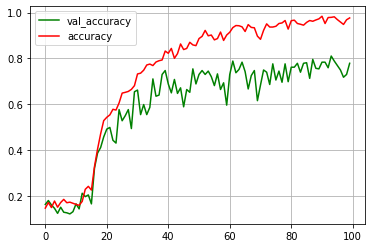

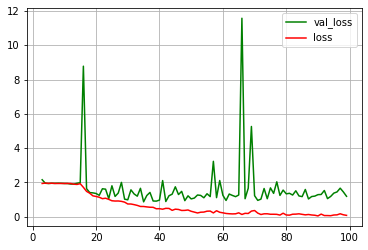

In [ ]:
df = pd.read_csv('../log/OtherModels/VGG16_adam_weights_16batch.csv', sep=',')
df[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
df[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Loading best weights
model_v.load_weights('../weights/OtherModels/VGG16_adam_weights_16batch.hdf5')

# Predicting
y_pred = model_v.predict(X_test)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.86      0.88      0.87        56
   bad_back_warp       0.83      0.83      0.83        59
        bad_head       0.53      0.63      0.58        54
bad_innner_thigh       0.80      0.87      0.84        47
     bad_shallow       0.90      0.94      0.92        68
         bad_toe       0.97      0.82      0.89        71
            good       0.69      0.61      0.65        56

        accuracy                           0.80       411
       macro avg       0.80      0.80      0.79       411
    weighted avg       0.81      0.80      0.80       411



#### SGD

In [ ]:
model_v_s = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(105,150,1)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

model_v_s.compile(optimizer='SGD',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath='../weights/OtherModels/VGG16_SGD_weights_16batch.hdf5',
      save_weights_only=False,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)

batch_size = 16 
epochs = 100 

history = model_v_s.fit(X_train, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_v_s.evaluate(X_test, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/OtherModels/VGG16_SGD_weights_16batch.csv')

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
77/77 - 9s - loss: 2.5455 - accuracy: 0.2443 - val_loss: 2.2984 - val_accuracy: 0.1849
Epoch 2/100
77/77 - 9s - loss: 1.5258 - accuracy: 0.4002 - val_loss: 2.0301 - val_accuracy: 0.2384
Epoch 3/100
77/77 - 9s - loss: 1.2725 - accuracy: 0.5138 - val_loss: 1.8629 - val_accuracy: 0.2871
Epoch 4/100
77/77 - 9s - loss: 1.1081 - accuracy: 0.5804 - val_loss: 1.4396 - val_accuracy: 0.4185
Epoch 5/100
77/77 - 9s - loss: 1.0082 - accuracy: 0.5982 - val_loss: 1.2405 - val_accuracy: 0.5182
Epoch 6/100
77/77 - 9s - loss: 0.8453 - accuracy: 0.6680 - val_loss: 1.1611 - val_accuracy: 0.5839
Epoch 7/100
77/77 - 9s - loss: 0.7959 - accuracy: 0.7037 - val_loss: 0.8675 - val_accuracy: 0.7032
Epoch 8/100
77/77 - 8s - loss: 0.6988 - accuracy: 0.7346 - val_loss: 0.9710 - val_accuracy: 0.6594
Epoch 9/100
77/77 - 8s - loss: 0.6320 - accuracy: 0.7606 - val_loss: 1.2513 - val_accuracy: 0.6156
Epoch 10/100
77/77 - 8s - loss: 0.5790 - accuracy: 0.7865 - val_loss: 1.1643 - val_accuracy: 0.6131
Epoch 11/

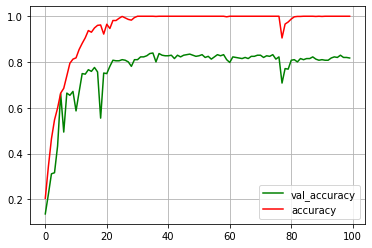

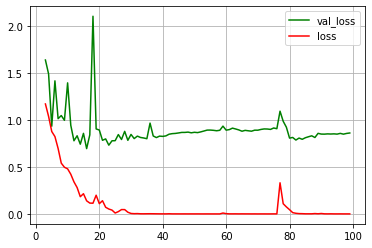

In [ ]:
df = pd.read_csv('../log/OtherModels/VGG16_SGD_weights_16batch.csv', sep=',')
df[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
df[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Loading best weights
model_v_s.load_weights('../weights/OtherModels/VGG16_SGD_weights_16batch.hdf5')

# Predicting test
y_pred = model_v_s.predict(X_test)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.87      0.80      0.83        56
   bad_back_warp       0.74      0.83      0.78        59
        bad_head       0.69      0.61      0.65        54
bad_innner_thigh       0.82      0.77      0.79        47
     bad_shallow       0.90      0.97      0.94        68
         bad_toe       0.91      0.85      0.88        71
            good       0.76      0.84      0.80        56

        accuracy                           0.82       411
       macro avg       0.81      0.81      0.81       411
    weighted avg       0.82      0.82      0.82       411



<a id=lstm-cnn></a> 
### LSTM -CNN 


Here we implement the *LSTM-CNN* architecture on keras and we trained it with *SGD optmizer* with batch size equal to 16.\
The model performs less well than the *Resnet*.

In [ ]:
from tensorflow.keras.layers import ConvLSTM2D

model_lstm = keras.models.Sequential([
    keras.layers.ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (1, 105, 150, 1)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(7, activation = "softmax")             
])

opt = keras.optimizers.SGD(lr=0.001)
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

X_train1 = X_train.reshape(1232, 1, 105, 150, 1)
X_val1 = X_val.reshape(411, 1, 105, 150, 1)
X_test1 = X_test.reshape(411, 1, 105, 150, 1)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath='../weights/OtherModels/CNNLSTM_SGD_weights_16batch.hdf5',
      save_weights_only=False,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)

batch_size = 16 
epochs = 100 

model_lstm.fit(X_train1, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val1, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_lstm.evaluate(X_test1, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/OtherModels/CNNLSTM_SGD_weights_16batch.csv')

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
77/77 - 19s - loss: 2.0915 - accuracy: 0.1542 - val_loss: 1.9400 - val_accuracy: 0.1265
Epoch 2/100
77/77 - 17s - loss: 1.9388 - accuracy: 0.1924 - val_loss: 1.9151 - val_accuracy: 0.2238
Epoch 3/100
77/77 - 26s - loss: 1.9027 - accuracy: 0.1964 - val_loss: 1.8722 - val_accuracy: 0.2822
Epoch 4/100
77/77 - 26s - loss: 1.8242 - accuracy: 0.2492 - val_loss: 1.7458 - val_accuracy: 0.3090
Epoch 5/100
77/77 - 12s - loss: 1.7473 - accuracy: 0.3093 - val_loss: 1.7001 - val_accuracy: 0.3017
Epoch 6/100
77/77 - 18s - loss: 1.6675 - accuracy: 0.3531 - val_loss: 1.5274 - val_accuracy: 0.4891
Epoch 7/100
77/77 - 12s - loss: 1.5544 - accuracy: 0.4058 - val_loss: 1.4648 - val_accuracy: 0.4672
Epoch 8/100
77/77 - 12s - loss: 1.4448 - accuracy: 0.4586 - val_loss: 1.5115 - val_accuracy: 0.4623
Epoch 9/100
77/77 - 17s - loss: 1.3971 - accuracy: 0.4976 - val_loss: 1.3136 - val_accuracy: 0.5474
Epoch 10/100
77/77 - 17s - loss: 1.2455 - accuracy: 0.5528 - val_loss: 1.1744 - val_accuracy: 0.6350

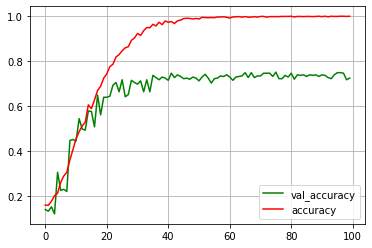

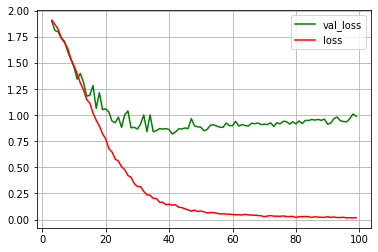

In [ ]:
df = pd.read_csv('../log/OtherModels/16batch_SGD_CONVLSTM.csv', sep=',')
df[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
df[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Loading best weights
model_lstm.load_weights('../weights/OtherModels/CNNLSTM_SGD_weights_16batch.hdf5')

# Predicting
y_pred = model_lstm.predict(X_test1)
y_pred = np.argmax(y_pred, axis = 1)
print(classification_report(y_test, y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.83      0.77      0.80        56
   bad_back_warp       0.71      0.76      0.74        59
        bad_head       0.61      0.69      0.64        54
bad_innner_thigh       0.79      0.72      0.76        47
     bad_shallow       0.84      0.91      0.87        68
         bad_toe       0.85      0.77      0.81        71
            good       0.81      0.77      0.79        56

        accuracy                           0.78       411
       macro avg       0.78      0.77      0.77       411
    weighted avg       0.78      0.78      0.78       411



<a id=otherResNet></a> 
## Extra ResNet attempts

### Normalization type 1

#### Adam optimizer with batch_size 32

In [ ]:
# Initalizing the model
model_norm1 = create_res_net('adam')
batch_size = 32 
epochs = 100  

#with this callback we save the weights of the best epoch in term of val_accuracy
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/OtherModels/stand_norm_adam_32batchweights.{epoch:02d}-{val_loss:.2f}.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model_norm1.fit(X_train_norm1, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val_norm1, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_norm1.evaluate(X_test_norm1, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/OtherModels/training32batch_stand_norm100.csv', index=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
39/39 - 26s - loss: 1.6004 - accuracy: 0.4083 - val_loss: 122.0357 - val_accuracy: 0.1217
Epoch 2/100
39/39 - 26s - loss: 1.4431 - accuracy: 0.4635 - val_loss: 26.1543 - val_accuracy: 0.1630
Epoch 3/100
39/39 - 27s - loss: 1.2299 - accuracy: 0.5609 - val_loss: 4.3825 - val_accuracy: 0.3212
Epoch 4/100
39/39 - 26s - loss: 1.1323 - accuracy: 0.6218 - val_loss: 4.0325 - val_accuracy: 0.2628
Epoch 5/100
39/39 - 26s - loss: 1.0739 - accuracy: 0.6063 - val_loss: 4.1108 - val_accuracy: 0.3309
Epoch 6/100
39/39 - 27s - loss: 0.9011 - accuracy: 0.6907 - val_loss: 4.2908 - val_accuracy: 0.3431
Epoch 7/100
39/39 - 26s - loss: 0.9043 - accuracy: 0.6810 - val_loss: 4.4935 - val_accuracy: 0.2993
Epoch 8/100
39/39 - 26s - loss: 0.9272 - accuracy: 0.6810 - val_loss: 2.3549 - val_accuracy: 0.3698
Epoch 9/100
39/39 - 26s - loss: 0.7244 - accuracy: 0.7427 - val_loss: 1.8504 - val_accuracy: 0.5231
Epoch 10/100
39/39 - 26s - loss: 0.7204 - accuracy: 0.7419 - val_loss: 2.3100 - val_accuracy: 0.4

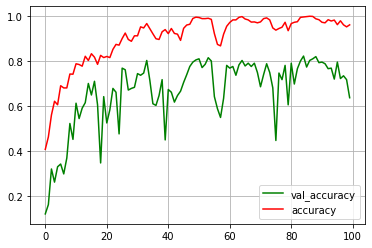

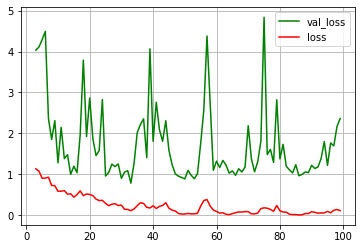

In [ ]:
history = pd.read_csv('../log/OtherModels/training32batch_stand_norm100.csv', sep=',')
history[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
history[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# The best epoch whose weigths we retrieve from is the 85th with a val_accuracy of 82% and a val loss of 1.03
model_norm1.load_weights('../weights/OtherModels/stand_norm_adam_32batchweights.85-1.03.hdf5')

# Prediction on the test set
y_pred = model_norm1.predict(X_test_norm1)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test, y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.77      0.96      0.86        56
   bad_back_warp       0.75      0.76      0.76        59
        bad_head       0.52      0.61      0.56        54
bad_innner_thigh       0.93      0.81      0.86        47
     bad_shallow       0.92      0.97      0.94        68
         bad_toe       0.94      0.83      0.88        71
            good       0.76      0.57      0.65        56

        accuracy                           0.80       411
       macro avg       0.80      0.79      0.79       411
    weighted avg       0.80      0.80      0.80       411



#### Adam optimizer with batch_size 16

In [ ]:
# Initalizing the model
model_norm1_vs2 = create_res_net('adam')
batch_size = 16
epochs = 100 

# with this callback we save the weights of the best epoch in term of val_accuracy
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/OtherModels/stand_norm_adam_16batch.{epoch:02d}-{val_loss:.2f}.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model_norm1_vs2.fit(X_train_norm1, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val_norm1, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_norm1_vs2.evaluate(X_test_norm1, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/OtherModels/training16batch_stand_norm100.csv', index=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
77/77 - 29s - loss: 2.5844 - accuracy: 0.2427 - val_loss: 110.6788 - val_accuracy: 0.1338
Epoch 2/100
77/77 - 27s - loss: 1.5435 - accuracy: 0.4269 - val_loss: 5.9653 - val_accuracy: 0.1290
Epoch 3/100
77/77 - 28s - loss: 1.3026 - accuracy: 0.5325 - val_loss: 3.9751 - val_accuracy: 0.2360
Epoch 4/100
77/77 - 27s - loss: 1.0999 - accuracy: 0.6136 - val_loss: 3.9832 - val_accuracy: 0.1946
Epoch 5/100
77/77 - 28s - loss: 1.0112 - accuracy: 0.6583 - val_loss: 2.7019 - val_accuracy: 0.3820
Epoch 6/100
77/77 - 28s - loss: 1.0498 - accuracy: 0.6356 - val_loss: 3.1967 - val_accuracy: 0.4088
Epoch 7/100
77/77 - 27s - loss: 0.8833 - accuracy: 0.6761 - val_loss: 7.5718 - val_accuracy: 0.2871
Epoch 8/100
77/77 - 28s - loss: 0.8378 - accuracy: 0.6981 - val_loss: 2.3909 - val_accuracy: 0.4623
Epoch 9/100
77/77 - 28s - loss: 0.7394 - accuracy: 0.7135 - val_loss: 1.2896 - val_accuracy: 0.6156
Epoch 10/100
77/77 - 27s - loss: 0.7421 - accuracy: 0.7305 - val_loss: 2.0624 - val_accuracy: 0.47

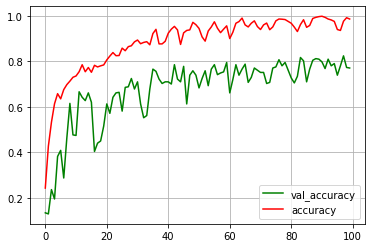

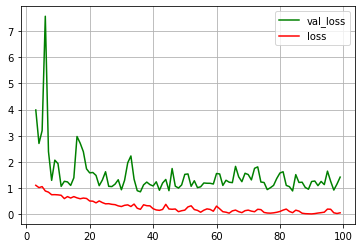

In [ ]:
history = pd.read_csv('../log/OtherModels/training16batch_stand_norm100.csv', sep=',')
history[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
history[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();


In [ ]:
#the best epoch whose weigths we retrieve from is the 98th with a val_accuracy of 82.48% and a val loss of 0.92
model_norm1_vs2.load_weights('../weights/OtherModels/stand_norm_adam_16batch.98-0.92.hdf5')

y_pred = model_norm1_vs2.predict(X_test_norm1)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test, y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.74      0.91      0.82        56
   bad_back_warp       0.79      0.71      0.75        59
        bad_head       0.60      0.54      0.57        54
bad_innner_thigh       0.93      0.85      0.89        47
     bad_shallow       0.86      1.00      0.93        68
         bad_toe       0.92      0.80      0.86        71
            good       0.65      0.66      0.65        56

        accuracy                           0.79       411
       macro avg       0.79      0.78      0.78       411
    weighted avg       0.79      0.79      0.79       411



### Normalization type 2

#### Adam optimizer with batch_size 32

In [ ]:
model = create_res_net('adam')
batch_size = 32 
epochs = 100

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/OtherModels/norm2_32_weightADAM.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model.fit(X_train_norm2, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val_norm2, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model.evaluate(X_test_norm2, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/OtherModels/norm2_32_weightADAM.csv', index = False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
39/39 - 27s - loss: 2.9112 - accuracy: 0.2468 - val_loss: 1413.5093 - val_accuracy: 0.1338
Epoch 2/100
39/39 - 24s - loss: 1.7465 - accuracy: 0.3734 - val_loss: 11.1635 - val_accuracy: 0.1217
Epoch 3/100
39/39 - 26s - loss: 1.5363 - accuracy: 0.4131 - val_loss: 13.6922 - val_accuracy: 0.1387
Epoch 4/100
39/39 - 26s - loss: 1.2299 - accuracy: 0.5284 - val_loss: 12.1039 - val_accuracy: 0.1411
Epoch 5/100
39/39 - 26s - loss: 1.1814 - accuracy: 0.5812 - val_loss: 26.3366 - val_accuracy: 0.1338
Epoch 6/100
39/39 - 28s - loss: 1.1248 - accuracy: 0.5942 - val_loss: 4.9919 - val_accuracy: 0.3066
Epoch 7/100
39/39 - 27s - loss: 1.0471 - accuracy: 0.6266 - val_loss: 6.4056 - val_accuracy: 0.1606
Epoch 8/100
39/39 - 27s - loss: 0.9123 - accuracy: 0.6769 - val_loss: 5.6942 - val_accuracy: 0.2263
Epoch 9/100
39/39 - 28s - loss: 0.8734 - accuracy: 0.6948 - val_loss: 2.3972 - val_accuracy: 0.4696
Epoch 10/100
39/39 - 28s - loss: 0.7698 - accuracy: 0.7305 - val_loss: 2.4711 - val_accuracy:

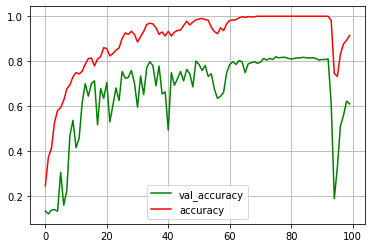

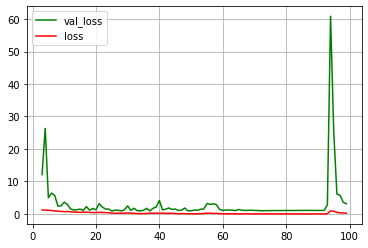

In [ ]:
df = pd.read_csv('../log/OtherModels/norm2_32_weightADAM.csv')
df[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
df[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Loading Best weights
model.load_weights('../weights/OtherModels/norm2_32_weightADAM.hdf5')

# Prediction on the test set
y_pred = model.predict(X_test_norm2)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.89      0.91      0.90        56
   bad_back_warp       0.83      0.88      0.85        59
        bad_head       0.70      0.59      0.64        54
bad_innner_thigh       0.85      0.87      0.86        47
     bad_shallow       0.86      0.97      0.91        68
         bad_toe       0.94      0.83      0.88        71
            good       0.75      0.77      0.76        56

        accuracy                           0.84       411
       macro avg       0.83      0.83      0.83       411
    weighted avg       0.84      0.84      0.83       411



#### Adam optimizer with batch_size 16

In [ ]:
model2 = create_res_net('adam')
batch_size = 16 
epochs = 100 

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/OtherModels/norm2_16_weightADAM.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model2.fit(X_train_norm2, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val_norm2, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model2.evaluate(X_test_norm2, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../weights/OtherModels/norm2_16_weightADAM.csv', index = False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
77/77 - 29s - loss: 2.8637 - accuracy: 0.2403 - val_loss: 19.3892 - val_accuracy: 0.1241
Epoch 2/100
77/77 - 29s - loss: 1.6653 - accuracy: 0.4172 - val_loss: 3.3110 - val_accuracy: 0.1703
Epoch 3/100
77/77 - 28s - loss: 1.2530 - accuracy: 0.5479 - val_loss: 6.6885 - val_accuracy: 0.2117
Epoch 4/100
77/77 - 28s - loss: 1.1637 - accuracy: 0.5755 - val_loss: 5.1704 - val_accuracy: 0.1582
Epoch 5/100
77/77 - 28s - loss: 1.0408 - accuracy: 0.6088 - val_loss: 2.3449 - val_accuracy: 0.4793
Epoch 6/100
77/77 - 28s - loss: 0.8584 - accuracy: 0.6948 - val_loss: 1.6108 - val_accuracy: 0.5523
Epoch 7/100
77/77 - 28s - loss: 0.8452 - accuracy: 0.6981 - val_loss: 1.2049 - val_accuracy: 0.6058
Epoch 8/100
77/77 - 28s - loss: 0.7621 - accuracy: 0.7273 - val_loss: 1.9895 - val_accuracy: 0.5401
Epoch 9/100
77/77 - 29s - loss: 0.6784 - accuracy: 0.7459 - val_loss: 1.2570 - val_accuracy: 0.6521
Epoch 10/100
77/77 - 28s - loss: 0.7248 - accuracy: 0.7240 - val_loss: 1.1929 - val_accuracy: 0.652

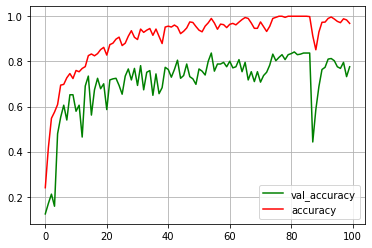

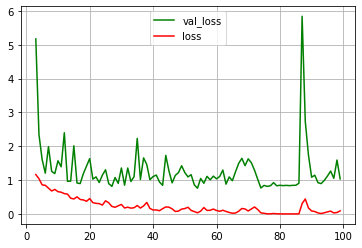

In [ ]:
df = pd.read_csv('../log/OtherModels/norm2_16_weightADAM.csv')
df[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid();
df[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Loading Best weights
model2.load_weights('../weights/OtherModels/norm2_16_weightADAM.hdf5')

# Prediction on the test set
y_pred = model2.predict(X_test_norm2)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.87      0.84      0.85        56
   bad_back_warp       0.74      0.86      0.80        59
        bad_head       0.65      0.56      0.60        54
bad_innner_thigh       0.94      0.94      0.94        47
     bad_shallow       0.94      0.94      0.94        68
         bad_toe       0.86      0.87      0.87        71
            good       0.76      0.75      0.76        56

        accuracy                           0.83       411
       macro avg       0.82      0.82      0.82       411
    weighted avg       0.83      0.83      0.83       411



### Normalization type 3

#### SGD 16 batch_size

In [ ]:
# Initialize the model
model_norm3_2 = create_res_net('SGD')

batch_size = 16 
epochs = 100 

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../weights/OtherModels/normWrist_SGD16.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model_norm3_2.fit(X_train_norm3, 
          y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val_norm3, y_val), 
          callbacks=[model_checkpoint_callback])

loss, accuracy = model_norm3_2.evaluate(X_test_norm3, y_test,
                                batch_size=batch_size,
                                verbose=False)

df = pd.DataFrame(history.history)
df.to_csv('../log/OtherModels/normWrist_SGD16.csv')

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
77/77 - 26s - loss: 2.2655 - accuracy: 0.2086 - val_loss: 2.0156 - val_accuracy: 0.1217
Epoch 2/100
77/77 - 26s - loss: 1.9524 - accuracy: 0.2508 - val_loss: 2.2267 - val_accuracy: 0.1363
Epoch 3/100
77/77 - 26s - loss: 1.6770 - accuracy: 0.3644 - val_loss: 1.8665 - val_accuracy: 0.3309
Epoch 4/100
77/77 - 27s - loss: 1.3226 - accuracy: 0.4968 - val_loss: 1.6221 - val_accuracy: 0.3504
Epoch 5/100
77/77 - 27s - loss: 1.0307 - accuracy: 0.6104 - val_loss: 1.6587 - val_accuracy: 0.4745
Epoch 6/100
77/77 - 28s - loss: 0.8456 - accuracy: 0.6810 - val_loss: 1.3122 - val_accuracy: 0.5718
Epoch 7/100
77/77 - 27s - loss: 0.6678 - accuracy: 0.7508 - val_loss: 1.1840 - val_accuracy: 0.5693
Epoch 8/100
77/77 - 28s - loss: 0.5615 - accuracy: 0.8133 - val_loss: 1.0516 - val_accuracy: 0.6326
Epoch 9/100
77/77 - 28s - loss: 0.4002 - accuracy: 0.8726 - val_loss: 0.9040 - val_accuracy: 0.6934
Epoch 10/100
77/77 - 27s - loss: 0.3460 - accuracy: 0.8953 - val_loss: 1.0265 - val_accuracy: 0.6837

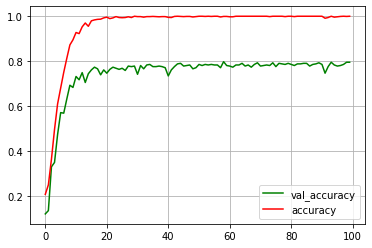

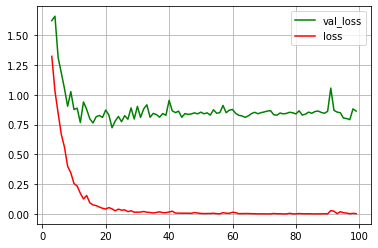

In [ ]:
df = pd.read_csv('../log/OtherModels/normWrist_SGD16.csv')
df[['val_accuracy', 'accuracy']].plot.line(color=['green','red']).grid()
df[['val_loss', 'loss']][3:].plot.line(color=['green','red']).grid();

In [ ]:
# Retrieve the best epoch from the val
model_norm3_2.load_weights('../weights/OtherModels/normWrist_SGD16.hdf5')

# Prediction on the test set
y_pred = model_norm3_2.predict(X_test_norm3)
y_pred = np.argmax(y_pred, axis =1)
print(classification_report(y_test,y_pred, target_names=classes))

                  precision    recall  f1-score   support

  bad_back_round       0.84      0.88      0.86        56
   bad_back_warp       0.77      0.80      0.78        59
        bad_head       0.71      0.59      0.65        54
bad_innner_thigh       0.86      0.79      0.82        47
     bad_shallow       0.83      0.96      0.89        68
         bad_toe       0.94      0.87      0.91        71
            good       0.73      0.79      0.76        56

        accuracy                           0.82       411
       macro avg       0.81      0.81      0.81       411
    weighted avg       0.82      0.82      0.82       411

